In [ ]:
# Install required packages
%pip install transformers torch matplotlib numpy --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.3 MB/s eta 0:00:00


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from collections import defaultdict

# Set up the model and tokenizer
model_name = "bert-base-uncased"
print(f"Loading model: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
model.eval()  # Set model to evaluation mode


Loading model: bert-base-uncased


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [11]:
def gradcam_activation(text, target_token):
    """GradCAM algorithm for neuron activation analysis"""
    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    token_index = tokens.index(target_token)

    # Get embeddings which can have gradients
    embeddings = model.get_input_embeddings()(inputs['input_ids'])
    embeddings.requires_grad = True

    # Forward pass with gradient calculation
    outputs = model(inputs_embeds=embeddings, output_hidden_states=True)
    hidden_states = outputs.hidden_states

    # Get gradients
    final_layer = hidden_states[-1]
    final_layer[0, token_index].sum().backward()

    # Calculate importance weights
    gradients = embeddings.grad[0, token_index]
    weights = torch.mean(gradients, dim=-1)

    # Get activation map
    activation_map = []
    for layer_output in hidden_states:
        weighted_activation = layer_output[0, token_index].detach() * weights
        activation_map.append(weighted_activation.numpy())

    return np.array(activation_map), tokens

def lime_activation(text, target_token, n_samples=50):
    """LIME algorithm for neuron activation analysis"""
    inputs = tokenizer(text, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    token_index = tokens.index(target_token)

    # Get original embeddings
    embeddings = model.get_input_embeddings()(inputs['input_ids'])
    original_output = model(inputs_embeds=embeddings, output_hidden_states=True).hidden_states

    # Generate perturbed samples
    activations = []
    print(f"Generating {n_samples} perturbed samples...")
    for i in range(n_samples):
        if i % 10 == 0:
            print(f"Processing sample {i}/{n_samples}")

        # Create perturbation mask
        mask = torch.rand_like(embeddings) > 0.5
        perturbed_embeds = embeddings * mask

        # Get activations for perturbed input
        with torch.no_grad():
            outputs = model(inputs_embeds=perturbed_embeds, output_hidden_states=True)
            hidden_states = outputs.hidden_states

            # Compare with original output
            layer_activations = []
            for orig_layer, pert_layer in zip(original_output, hidden_states):
                diff = (orig_layer - pert_layer)[0, token_index].numpy()
                layer_activations.append(diff)
            activations.append(layer_activations)

    # Calculate importance scores
    importance_scores = np.mean(activations, axis=0)
    return importance_scores, tokens


In [12]:
# NOTE: This function requires 'tokenizer' and 'model' to be defined in a previous cell.
def gradcam_activation(text, target_token):
    """Improved GradCAM algorithm for neuron activation analysis"""
    inputs = tokenizer(text, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    # Find token index (handles subword tokens too, like '##fox')
    try:
        token_index = next(i for i, tok in enumerate(tokens) if target_token in tok)
    except StopIteration:
        raise ValueError(f"Token '{target_token}' not found in tokens: {tokens}")

    # Get input embeddings for gradient tracking
    input_ids = inputs['input_ids']
    embedding_layer = model.get_input_embeddings()
    embeddings = embedding_layer(input_ids)
    embeddings.retain_grad()  # Track gradients

    # Forward pass using embeddings
    outputs = model(inputs_embeds=embeddings, output_hidden_states=True)
    hidden_states = outputs.hidden_states  # List of [batch, seq_len, hidden_dim]

    # Backpropagate from the output of the final layer at target token
    target_output = hidden_states[-1][0, token_index]
    target_output.sum().backward()

    # Get gradients of the embeddings
    gradients = embeddings.grad[0, token_index]  # Shape: [hidden_dim]

    # Compute weighted activation per neuron per layer
    activation_map = []
    for layer_output in hidden_states:
        activation_vector = layer_output[0, token_index]  # Shape: [hidden_dim]
        weighted_activation = (activation_vector * gradients).detach().numpy()
        activation_map.append(weighted_activation)

    return np.array(activation_map), tokens


In [13]:
def lime_activation(text, target_token, n_samples=50):
    """LIME algorithm for neuron activation analysis"""
    inputs = tokenizer(text, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    try:
        token_index = next(i for i, tok in enumerate(tokens) if target_token in tok)
    except StopIteration:
        raise ValueError(f"Token '{target_token}' not found in tokens: {tokens}")

    # Get original embeddings
    embeddings = model.get_input_embeddings()(inputs['input_ids'])
    original_output = model(inputs_embeds=embeddings, output_hidden_states=True).hidden_states

    # Generate perturbed samples
    activations = []
    print(f"Generating {n_samples} perturbed samples...")
    for i in range(n_samples):
        if i % 10 == 0:
            print(f"Processing sample {i}/{n_samples}")

        # Create perturbation mask
        mask = torch.rand_like(embeddings) > 0.5
        perturbed_embeds = embeddings * mask

        # Get activations for perturbed input
        with torch.no_grad():
            outputs = model(inputs_embeds=perturbed_embeds, output_hidden_states=True)
            hidden_states = outputs.hidden_states

            # Compare with original output
            layer_activations = []
            for orig_layer, pert_layer in zip(original_output, hidden_states):
                diff = (orig_layer - pert_layer)[0, token_index].numpy()
                layer_activations.append(diff)
            activations.append(layer_activations)

    # Calculate importance scores
    importance_scores = np.mean(activations, axis=0)
    return importance_scores, tokens



Analyzing text: 'The quick brown fox jumps over the lazy dog.'
Target token: 'fox'

Running GradCAM analysis...
GradCAM analysis complete!

Running LIME analysis...
Generating 50 perturbed samples...
Processing sample 0/50
GradCAM analysis complete!

Running LIME analysis...
Generating 50 perturbed samples...
Processing sample 0/50
Processing sample 10/50
Processing sample 10/50
Processing sample 20/50
Processing sample 20/50
Processing sample 30/50
Processing sample 30/50
Processing sample 40/50
Processing sample 40/50
LIME analysis complete!
LIME analysis complete!


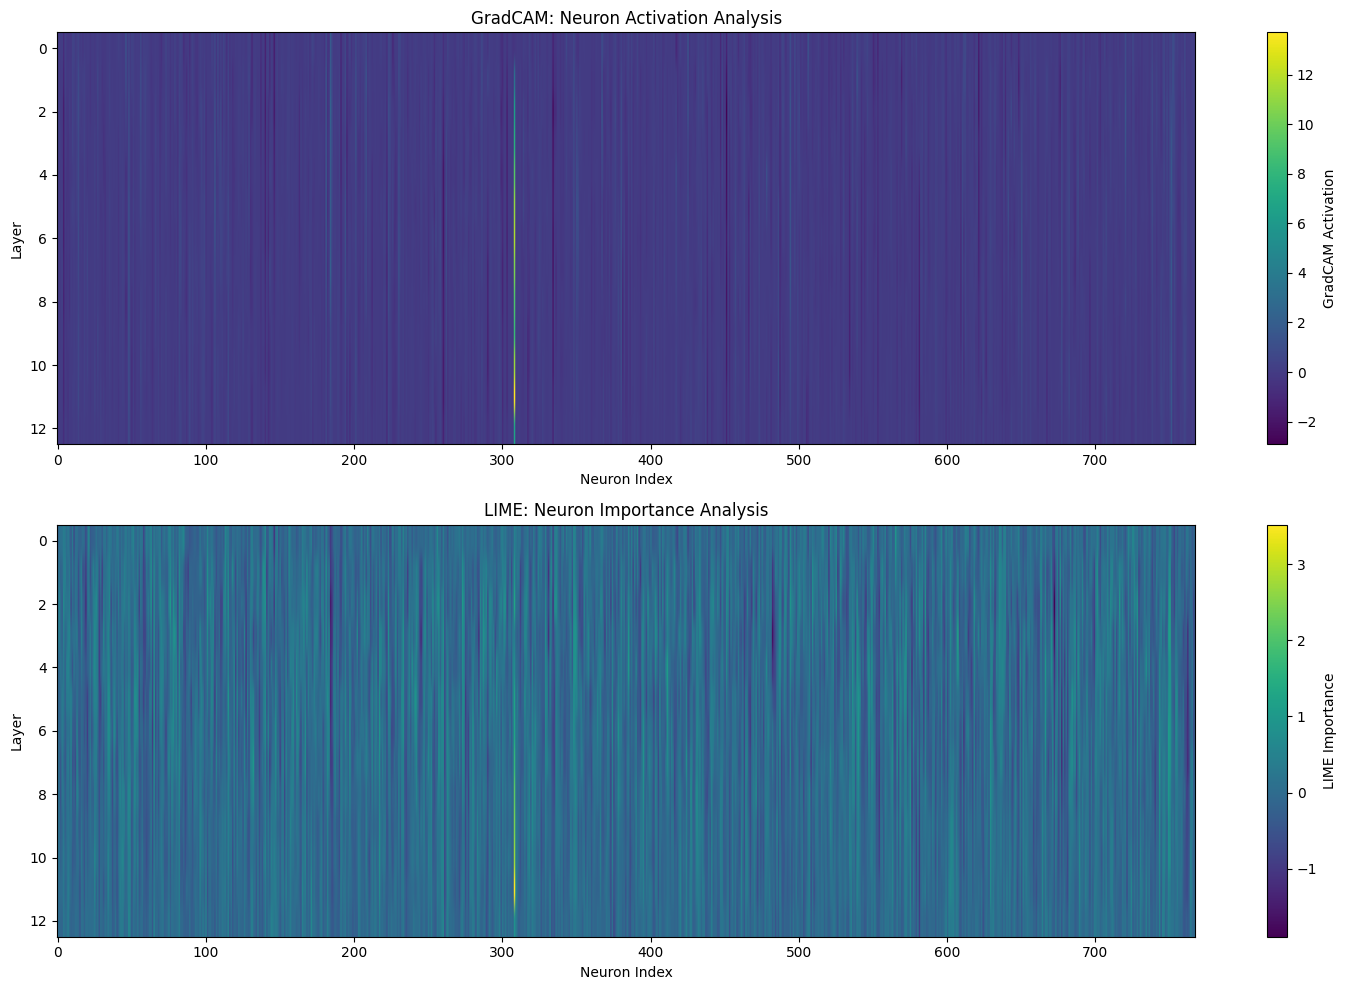


Top 5 neurons identified by GradCAM:

Layer 0:
  Neuron 506: 1.2859
  Neuron 140: -1.3066
  Neuron 146: -1.5669
  Neuron 621: -1.5857
  Neuron 184: 1.8727

Layer 1:
  Neuron 334: -1.5752
  Neuron 621: -1.8525
  Neuron 184: 1.8665
  Neuron 451: -2.0603
  Neuron 308: 3.1658

Layer 2:
  Neuron 621: -1.8444
  Neuron 184: 2.3486
  Neuron 334: -2.3534
  Neuron 451: -2.9139
  Neuron 308: 6.2608

Layer 3:
  Neuron 260: -1.5465
  Neuron 184: 1.9780
  Neuron 334: -2.0394
  Neuron 451: -2.4253
  Neuron 308: 7.4838

Layer 4:
  Neuron 260: -1.9416
  Neuron 334: -1.9743
  Neuron 184: 1.9903
  Neuron 451: -2.3775
  Neuron 308: 9.2949

Layer 5:
  Neuron 334: -1.8151
  Neuron 260: -1.9234
  Neuron 184: 2.0300
  Neuron 451: -2.1949
  Neuron 308: 11.0136

Layer 6:
  Neuron 451: -1.7034
  Neuron 184: 1.9189
  Neuron 260: -2.0089
  Neuron 334: -2.0749
  Neuron 308: 11.6310

Layer 7:
  Neuron 260: -1.8346
  Neuron 334: -2.0400
  Neuron 451: -2.0519
  Neuron 184: 2.1929
  Neuron 308: 10.3752

Layer 8:
  Neu

In [14]:
# Example text and target token
text = "The quick brown fox jumps over the lazy dog."
target_token = "fox"  # We'll analyze this token

print(f"\nAnalyzing text: '{text}'")
print(f"Target token: '{target_token}'")

# Run GradCAM analysis
print("\nRunning GradCAM analysis...")
gradcam_results, tokens = gradcam_activation(text, target_token)
print("GradCAM analysis complete!")

# Run LIME analysis
print("\nRunning LIME analysis...")
lime_results, _ = lime_activation(text, target_token)
print("LIME analysis complete!")

# Create visualization
plt.figure(figsize=(15, 10))

# Plot GradCAM results
plt.subplot(2, 1, 1)
plt.imshow(gradcam_results, aspect='auto', cmap='viridis')
plt.colorbar(label='GradCAM Activation')
plt.title('GradCAM: Neuron Activation Analysis')
plt.xlabel('Neuron Index')
plt.ylabel('Layer')

# Plot LIME results
plt.subplot(2, 1, 2)
plt.imshow(lime_results, aspect='auto', cmap='viridis')
plt.colorbar(label='LIME Importance')
plt.title('LIME: Neuron Importance Analysis')
plt.xlabel('Neuron Index')
plt.ylabel('Layer')

plt.tight_layout()
plt.show()

# Print analysis of top neurons
def print_top_neurons(results, algorithm_name, n_top=5):
    print(f"\nTop {n_top} neurons identified by {algorithm_name}:")
    for layer_idx in range(len(results)):
        layer_scores = results[layer_idx]
        top_indices = np.argsort(np.abs(layer_scores))[-n_top:]
        top_values = layer_scores[top_indices]
        print(f"\nLayer {layer_idx}:")
        for idx, value in zip(top_indices, top_values):
            print(f"  Neuron {idx}: {value:.4f}")

print_top_neurons(gradcam_results, "GradCAM")
print_top_neurons(lime_results, "LIME")


🧠 What Is Neuron Activation Analysis?
It's the process of:

Tracking neuron outputs layer-by-layer for a specific input

Analyzing gradient influence (GradCAM) or input perturbation effects (LIME)

Finding out which neurons are important for certain tokens, decisions, or classes

🎯 Why Use These Algorithms?
1. Interpretability & Explainability
🔍 "Why did the model predict this?"

GradCAM shows which neurons (features) were activated most for a specific input (e.g., the token "fox").

LIME perturbs the input and learns which neurons change the model’s output the most.

Together, they help you see what the model focuses on, making the black box more transparent.



🔧 Practical Uses
1. Debugging Models
Check if the model is focusing on the right tokens.

Example: Did BERT attend to the word “not” in a negative sentence? If not, it may fail.

2. Model Transparency for Users
Especially useful in medical, legal, or financial AI, where decisions must be explainable.

“Why was this document classified as toxic?” → LIME/GradCAM tells you which tokens/neuron layers contributed.

3. Identifying Biases
Suppose BERT activates strongly on gendered terms (e.g., “he”/“she”) for unrelated tasks — you can detect and reduce bias using neuron analysis.

4. Model Compression / Pruning
If certain neurons never activate or aren’t useful, you can remove them to make the model smaller and faster.

5. Fine-Tuning Insights
Helps decide which layers to unfreeze during fine-tuning.

For example, if only layers 10–12 contribute heavily, you might freeze layers 0–9.

📈 Real-world Example
Let’s say you're building a sentiment classifier:

Input: "The movie was not good."
Token: "not"

If neuron analysis shows high activation for "good" but almost nothing for "not", the model will wrongly classify it as positive. Neuron analysis helps you catch and fix that.

# ** Models used** **🔶 GradCAM for Neuron Activation (NLP)**
✅ Algorithm: GradCAM for BERT

Input:
- Text input (string)
- Target token (string)
- Pretrained Transformer model (e.g., BERT)

Steps:

1. Tokenize the input text to get input_ids.
2. Convert input_ids to embeddings using model’s embedding layer.
3. Mark the embeddings for gradient tracking (`retain_grad()`).
4. Forward pass the embeddings through the model to get hidden_states.
5. Identify the position of the target token (handle subword tokens).
6. From the last hidden layer, select the activation at the target token.
7. Perform backward pass: call `.backward()` on the target activation.
8. Retrieve the gradient of the embeddings at the target token.
9. For each layer:
    a. Extract neuron activations at the target token.
    b. Multiply each neuron activation by its corresponding gradient weight.
10. Return the weighted neuron activations as a matrix: [layers x neurons].

Output:
- Activation heatmap indicating important neurons across layers.

# **🔷 LIME for Neuron Activation (NLP)**

✅ Algorithm: LIME for BERT Neurons
plaintext
Copy
Edit
Input:
- Text input (string)
- Target token (string)
- Pretrained model
- n_samples: number of perturbations

Steps:

1. Tokenize the input and find the target token index.
2. Initialize an empty list to store neuron activations.
3. For each of n_samples:
    a. Randomly mask (or perturb) some tokens in the input_ids.
    b. Forward pass the perturbed input through the model.
    c. From each hidden layer, extract activations for the target token.
    d. Append the activations (list of neuron vectors) to the list.
4. After all samples, average the neuron activations across samples.
5. The resulting average vector for each layer shows neuron importance.

Output:
- Average neuron importance matrix: [layers x neurons]